In [19]:
#@title Graph metrics report - Zogenix Inc Contract
!pip install ace-tools-open
import ace_tools_open as tools
import json
import pandas as pd
import networkx as nx
from collections import Counter, defaultdict
import re


In [20]:
!pip install ipywidgets
!nbextension enable --py widgetsnbextension


/bin/bash: line 1: nbextension: command not found


In [21]:
#@title Linter Report - Zogenix Inc
import ace_tools_open as tools
from google.colab import drive

drive.mount("/content/drive")
GRAPH_DIR = "/content/drive/MyDrive/output_gemini_robust"


json_path = "/content/drive/MyDrive/output_gemini_robust/ZogenixInc_20190509_10-Q_EX-10.2_11663313_EX-10.2_Distributor Agreement_nupunkt_graph.json"
with open(json_path, "r") as f:
    graph_data = json.load(f)

nodes = graph_data.get("nodes", [])
edges = graph_data.get("edges", [])

#Calculate graph metrics

#Build undirected graph from our json to perform structural connectivity checks
G = nx.Graph()
for node in nodes:
    G.add_node(node["id"], **node)
for e in edges:
    u = e.get("source") or e.get("src")
    v = e.get("target") or e.get("tgt")
    if u and v:
        G.add_edge(u, v, **e)

node_attr = dict(G.nodes(data=True))
node_type = {n: node_attr[n].get("type", "UNKNOWN") for n in G.nodes()}
node_label = {n: node_attr[n].get("label", n) for n in G.nodes()}

def edges_of_type(g, etype):
    return [(u, v, d) for u, v, d in g.edges(data=True) if d.get("type") == etype]

#Unused Definitions
ref_edges = edges_of_type(G, "REFERS_TO")
ref_in_targets = Counter([v if node_type.get(v) == "DEFINED_TERM" else None for u, v, _ in ref_edges])
unused_definition_nodes = []
for n in G.nodes():
    if node_type.get(n) == "DEFINED_TERM":
        cnt = sum(1 for u, v, _ in ref_edges if v == n)
        if cnt == 0:
            unused_definition_nodes.append(n)

#Undefined References
undefined_reference_edges = []
for u, v, d in ref_edges:
    if node_type.get(v) not in {"DEFINED_TERM", "CLAUSE"}:
        undefined_reference_edges.append((u, v, d))

#Duplicate/conflicting definitions
def normalize_term(lbl):
    t = lbl
    t = re.sub(r'["“”]', '', str(t))
    t = t.strip().lower()
    return t

term_groups = defaultdict(list)
for n in G.nodes():
    if node_type.get(n) == "DEFINED_TERM":
        term_groups[normalize_term(node_label.get(n, ""))].append(n)

duplicate_definitions = {k: v for k, v in term_groups.items() if k and len(v) > 1}

#Circular term references
DG_terms = nx.DiGraph()
for n in G.nodes():
    if node_type.get(n) == "DEFINED_TERM":
        DG_terms.add_node(n)
for u, v, d in ref_edges:
    if node_type.get(u) == "DEFINED_TERM" and node_type.get(v) == "DEFINED_TERM":
        DG_terms.add_edge(u, v)

cycles_terms = list(nx.simple_cycles(DG_terms))

#Orphan nodes: degree 0
orphans = [n for n, d in G.degree() if d == 0]

#Leaf nodes: degree 1
leaves = [n for n, d in G.degree() if d == 1]
leaf_clauses = [n for n in leaves if node_type.get(n) == "CLAUSE"]

#Articulation points (critical nodes)
art_points = list(nx.articulation_points(G))

#Isolated components
components = sorted(nx.connected_components(G), key=len, reverse=True)
main_comp = components[0] if components else set()
isolated_components = [c for c in components[1:] if len(c) <= 8]  # small components worth flagging

#High-degree "god nodes"
deg = dict(G.degree())
top_degree = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]

#Broken cross-references: REFERS_TO targets missing
broken_xrefs = []
for u, v, d in ref_edges:
    if v not in G.nodes():
        broken_xrefs.append((u, v, d))

#k-core (main component only)
k_core_k = None
if main_comp:
    H = G.subgraph(main_comp).copy()
    try:
        core_nums = nx.core_number(H)
        k_core_k = max(core_nums.values())
    except nx.NetworkXError:
        k_core_k = None


#Create report
rows = []

#Unused definitions
for n in unused_definition_nodes:
    rows.append({
        "Severity": "Warning",
        "Rule": "UnusedDefinition",
        "NodeID": n,
        "NodeLabel": node_label[n],
        "Details": "Defined term is never referenced via REFERS_TO."
    })

#Undefined references (unexpected targets)
for (u, v, d) in undefined_reference_edges:
    rows.append({
        "Severity": "Error",
        "Rule": "UndefinedReference",
        "NodeID": u,
        "NodeLabel": node_label[u],
        "Details": f"REFERS_TO points to unexpected target type '{node_type.get(v)}' (Node {v})."
    })

#Duplicate definitions
for norm, ids in duplicate_definitions.items():
    rows.append({
        "Severity": "Error",
        "Rule": "DuplicateDefinition",
        "NodeID": ", ".join(ids),
        "NodeLabel": "; ".join([node_label[i] for i in ids]),
        "Details": f"Multiple DEFINED_TERM nodes share normalized label '{norm}'."
    })

#Circular term references
for cyc in cycles_terms:
    rows.append({
        "Severity": "Warning",
        "Rule": "CircularDefinition",
        "NodeID": " -> ".join(cyc),
        "NodeLabel": " -> ".join([node_label[i] for i in cyc]),
        "Details": "Cycle among DEFINED_TERM via REFERS_TO."
    })

#Orphans
for n in orphans:
    rows.append({
        "Severity": "Warning",
        "Rule": "OrphanNode",
        "NodeID": n,
        "NodeLabel": node_label[n],
        "Details": f"Node of type {node_type.get(n)} has no connections."
    })

#Leaf clauses
for n in leaf_clauses:
    rows.append({
        "Severity": "Info",
        "Rule": "LeafClause",
        "NodeID": n,
        "NodeLabel": node_label[n],
        "Details": "Clause is referenced only once; verify intended narrow scope."
    })

#Articulation points
for n in art_points:
    rows.append({
        "Severity": "Info",
        "Rule": "ArticulationPoint",
        "NodeID": n,
        "NodeLabel": node_label[n],
        "Details": "Removal would increase the number of connected components (high structural impact)."
    })

#Isolated components
for comp in isolated_components:
    labels = [node_label[n] for n in comp]
    types = Counter([node_type[n] for n in comp])
    rows.append({
        "Severity": "Warning",
        "Rule": "IsolatedComponent",
        "NodeID": ", ".join(list(comp)[:8]),
        "NodeLabel": "; ".join(labels[:8]),
        "Details": f"Small disconnected subgraph with {len(comp)} nodes; types={dict(types)}."
    })

#Broken cross refs
for (u, v, d) in broken_xrefs:
    rows.append({
        "Severity": "Error",
        "Rule": "BrokenCrossReference",
        "NodeID": u,
        "NodeLabel": node_label[u],
        "Details": f"REFERS_TO points to non-existent node id {v}."
    })

report_df = pd.DataFrame(rows)

#Create summary
summary = {
    "contract_name": graph_data.get("name", "Zogenix Inc. Distributor Agreement"),
    "total_nodes": G.number_of_nodes(),
    "total_edges": G.number_of_edges(),
    "orphans": len(orphans),
    "leaves": len(leaves),
    "leaf_clauses": len(leaf_clauses),
    "articulation_points": len(art_points),
    "unused_defined_terms": len(unused_definition_nodes),
    "duplicate_definitions_groups": len(duplicate_definitions),
    "circular_def_cycles": len(cycles_terms),
    "isolated_components_small": len(isolated_components),
    "k_core_k": k_core_k,
    "broken_cross_refs": len(broken_xrefs)
}
summary_df = pd.DataFrame([summary])

tools.display_dataframe_to_user("Legal Linter Report - Zogenix", report_df)
tools.display_dataframe_to_user("Legal Linter Summary - Zogenix", summary_df)

report_path = "/content/drive/MyDrive/N=1/legal_linter_report_zogenix.csv"
summary_path = "/content/drive/MyDrive/N=1/legal_linter_summary_zogenix.csv"
report_df.to_csv(report_path, index=False)
summary_df.to_csv(summary_path, index=False)

(report_path, summary_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Legal Linter Report - Zogenix


Loading ITables v2.5.2 from the internet... (need help?)


Legal Linter Summary - Zogenix


Loading ITables v2.5.2 from the internet... (need help?)


('/content/drive/MyDrive/N=1/legal_linter_report_zogenix.csv',
 '/content/drive/MyDrive/N=1/legal_linter_summary_zogenix.csv')

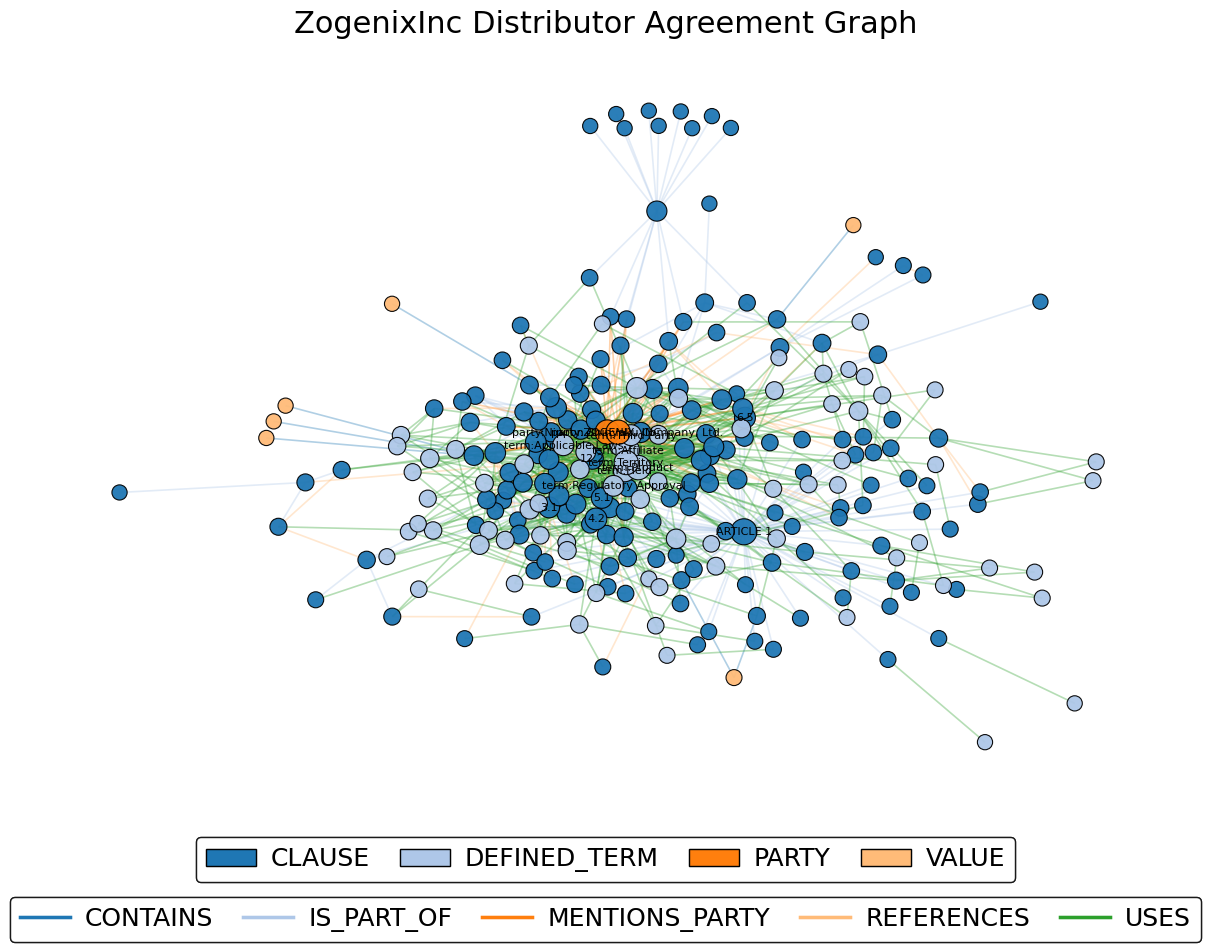

In [22]:
#@title Visualize Zogenix Inc Graph and Highlights
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

LEAF_COLOR = "#98FB98"   # light green
ART_COLOR  = "#0B3D91"   # dark blue
ORPHAN_COLOR = "#E45756"
FONTSIZE = 22
LABEL_TOP_K = 15
SAVE = False
OUT_DIR = "."
FIG_DPI = 300


#Force absolute black for all text by default
mpl.rcParams.update({
    "text.color": "black",
    "axes.labelcolor": "black",
    "axes.titlecolor": "black",
})

#Legend helpers
import matplotlib as mpl
mpl.rcParams.update({"text.color":"black","axes.labelcolor":"black","axes.titlecolor":"black"})

def _legend_to_black(*legs):
    for leg in legs or []:
        if not leg:
            continue
        leg.get_frame().set_edgecolor("black")
        if leg.get_title(): leg.get_title().set_color("black")
        for t in leg.get_texts(): t.set_color("black")

def fig_bottom_legend(fig, handles, title=None, y=0.04, ncol=None):
    """Create a HORIZONTAL legend at the bottom of the *figure* (not the axes)."""
    """Horizontal legend at the bottom of the *figure*."""
    if not handles:
        return None
    if ncol is None:
        ncol = max(1, len(handles))
    leg = fig.legend(handles=handles, loc="lower center",
                     bbox_to_anchor=(0.5, y), ncol=ncol,
                     frameon=True, title=title, columnspacing=1.2, handletextpad=0.6,
                     prop={"size": 18})
    title_fontsize=18
    if title_fontsize is not None and leg.get_title():
        leg.get_title().set_fontsize(title_fontsize)
    fig.add_artist(leg)
    try:
        _legend_to_black(leg)
    except NameError:
        pass
    return leg

H = G.subgraph(main_comp).copy() if main_comp else G

node_attrs = dict(G.nodes(data=True))
NODE_TYPE  = {n: node_attrs.get(n, {}).get("type", "UNKNOWN") for n in G.nodes()}
NODE_LABEL = {n: node_attrs.get(n, {}).get("label", str(n)) for n in G.nodes()}

degH      = dict(H.degree())
leavesH   = [n for n, d in H.degree() if d == 1]
orphans_all = [n for n, d in G.degree() if d == 0]
art_points_H = list(nx.articulation_points(H))

node_types_present = {NODE_TYPE.get(n, "UNKNOWN") for n in H.nodes()}
edge_types_present = {d.get("type", "UNKNOWN") for _, _, d in H.edges(data=True)}
def palette(categories, cmap_name="tab20"):
    cats = sorted(str(c) for c in categories if c is not None)
    cmap = plt.get_cmap(cmap_name)
    return {c: cmap(i % cmap.N) for i, c in enumerate(cats)} | {"UNKNOWN": (0.6, 0.6, 0.6, 1.0)}
node_pal = palette(node_types_present or {"UNKNOWN"})
edge_pal = palette(edge_types_present or {"UNKNOWN"})

def compute_layout(H):
    order = ["CLAUSE", "DEFINED_TERM", "PARTY", "VALUE", "UNKNOWN"]
    shells = []
    for t in order:
        group = [n for n in H.nodes() if NODE_TYPE.get(n, "UNKNOWN") == t]
        group = sorted(group, key=lambda n: H.degree(n), reverse=True)
        if group: shells.append(group)
    if not shells:
        return nx.spring_layout(H, k=0.9, iterations=200, seed=42)
    pos0 = nx.shell_layout(H, nlist=shells, scale=1.0)
    return nx.spring_layout(H, pos=pos0, k=0.35, iterations=150, seed=42)

pos = compute_layout(H)

def orphan_ring_positions(orphans, base_pos, scale=1.35):
    if not orphans: return {}
    xs = [x for x, y in base_pos.values()]
    ys = [y for x, y in base_pos.values()]
    cx, cy = (min(xs)+max(xs))/2, (min(ys)+max(ys))/2
    span = max(max(xs)-min(xs), max(ys)-min(ys))
    r = (span/2.0) * scale + 0.1
    k = len(orphans)
    return {n: (cx + r*math.cos(2*math.pi*i/k), cy + r*math.sin(2*math.pi*i/k))
            for i, n in enumerate(orphans)}

pos_orphans = orphan_ring_positions(orphans_all, pos)
pos2 = {**pos, **pos_orphans}

def nsize(n, base=90, scale=30):
    return base + scale * math.sqrt(degH.get(n, 0))
def hub_labels(H, k=25):
    hubs = [n for n, _ in sorted(H.degree(), key=lambda x: x[1], reverse=True)[:k]]
    return {n: NODE_LABEL.get(n, str(n)) for n in hubs}

def draw_typed_graph_clean():
    fig = plt.figure(figsize=(12, 10)); ax = plt.gca()
    ax.set_title("ZogenixInc Distributor Agreement Graph", pad=12, color="black", fontsize=FONTSIZE)

    for et in sorted(edge_pal.keys()):
        edgelist = [(u, v) for u, v, d in H.edges(data=True) if str(d.get("type","UNKNOWN")) == et]
        if edgelist:
            nx.draw_networkx_edges(H, pos, edgelist=edgelist, width=1.2, alpha=0.35,
                                   edge_color=[edge_pal[et]])

    for nt in sorted(node_pal.keys()):
        nodelist = [n for n in H.nodes() if str(NODE_TYPE.get(n,"UNKNOWN")) == nt]
        if nodelist:
            nx.draw_networkx_nodes(H, pos, nodelist=nodelist,
                                   node_size=[nsize(n) for n in nodelist],
                                   node_color=[node_pal[nt]], edgecolors="black",
                                   linewidths=0.8, alpha=0.95)

    nx.draw_networkx_labels(H, pos, labels=hub_labels(H, k=LABEL_TOP_K), font_size=8)

    node_types = [nt for nt in sorted(node_pal.keys()) if nt != "UNKNOWN"]
    edge_types = [et for et in sorted(edge_pal.keys()) if et != "UNKNOWN"]

    plt.subplots_adjust(bottom=0.22)
    leg_nodes = leg_edges = None
    if node_types:
        node_handles = [Patch(facecolor=node_pal[nt], edgecolor="black", label=f"{nt}") for nt in node_types]
        leg_nodes = fig_bottom_legend(fig, node_handles, y=0.10)
    if edge_types:
        edge_handles = [Line2D([0],[0], color=edge_pal[et], lw=2.5, label=f"{et}") for et in edge_types]
        leg_edges = fig_bottom_legend(fig, edge_handles, y=0.04)

    ax.set_axis_off()
    plt.tight_layout(rect=(0, 0.18, 1, 1))
    if SAVE:
        plt.savefig(os.path.join(OUT_DIR, "01_graph_typed_clean.png"), dpi=FIG_DPI, bbox_inches="tight")
    plt.show()


draw_typed_graph_clean()


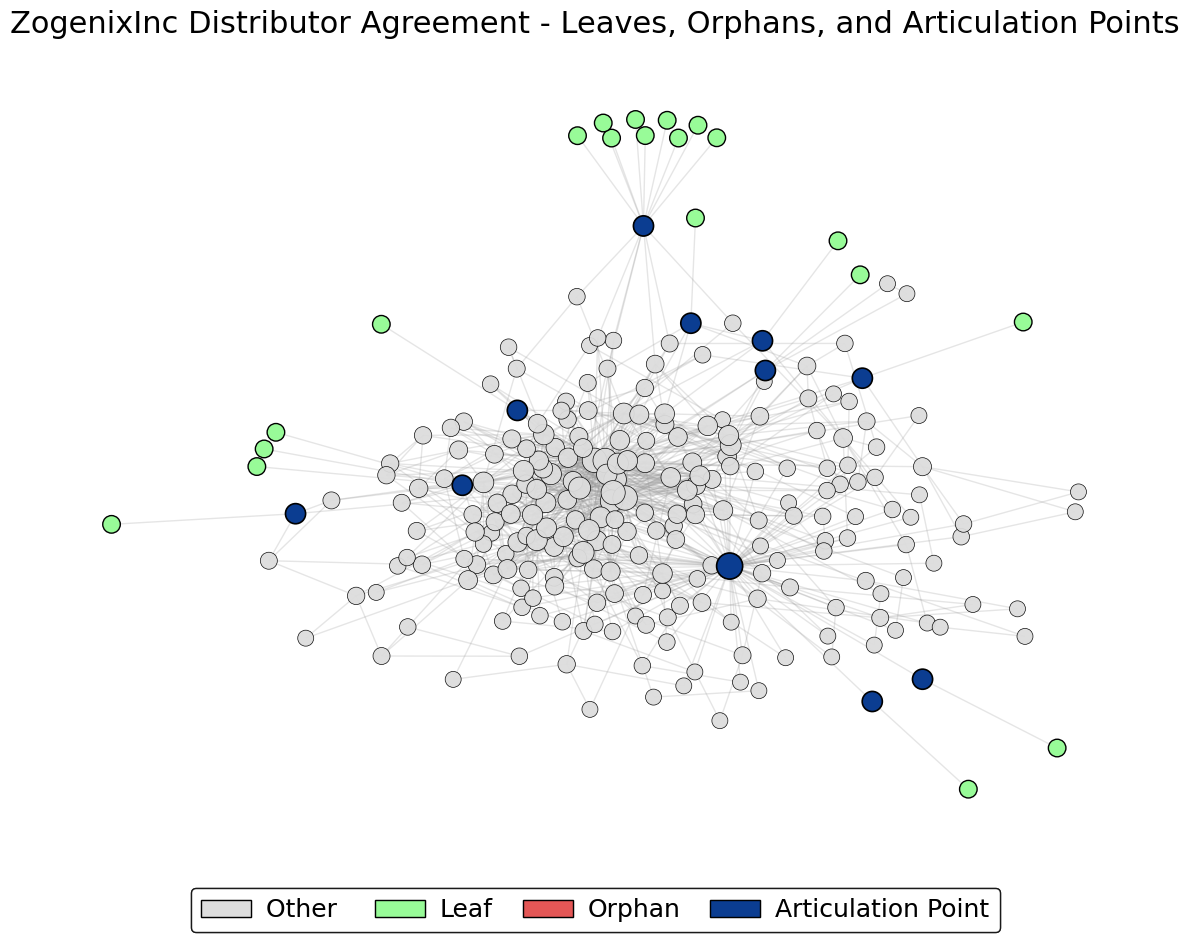

In [23]:
def draw_leaves_orphans_and_articulation():
    fig = plt.figure(figsize=(12, 10)); ax = plt.gca()
    ax.set_title("ZogenixInc Distributor Agreement - Leaves, Orphans, and Articulation Points", pad=12, color="black", fontsize=FONTSIZE)

    nx.draw_networkx_edges(H, pos, width=1.0, alpha=0.25, edge_color="#999999")
    base_nodes = [n for n in H.nodes() if n not in set(leavesH)]
    nx.draw_networkx_nodes(H, pos, nodelist=base_nodes,
                           node_size=[nsize(n) for n in base_nodes],
                           node_color="#DDDDDD", edgecolors="black", linewidths=0.5, alpha=0.95)
    nx.draw_networkx_nodes(H, pos, nodelist=leavesH,
                           node_size=[max(nsize(n), 160) for n in leavesH],
                           node_color=LEAF_COLOR, edgecolors="black", linewidths=1.0, alpha=1.0, label="Leaf")
    if orphans_all:
        nx.draw_networkx_nodes(G, pos2, nodelist=orphans_all,
                               node_size=190, node_color=ORPHAN_COLOR,
                               edgecolors="black", linewidths=1.2, alpha=1.0, label="Orphan")
    if art_points_H:
        nx.draw_networkx_nodes(H, pos, nodelist=art_points_H,
                               node_size=[max(nsize(n), 210) for n in art_points_H],
                               node_color=ART_COLOR, edgecolors="black", linewidths=1.2,
                               alpha=1.0, label="Articulation")

    handles = [
        Patch(facecolor="#DDDDDD", edgecolor="black", label="Other "),
        Patch(facecolor=LEAF_COLOR, edgecolor="black", label="Leaf"),
        Patch(facecolor=ORPHAN_COLOR, edgecolor="black", label="Orphan"),
        Patch(facecolor=ART_COLOR, edgecolor="black", label="Articulation Point"),
    ]
    plt.subplots_adjust(bottom=0.12)
    fig_bottom_legend(fig, handles, title=None, y=0.05)

    ax.set_axis_off()
    plt.tight_layout(rect=(0, 0.12, 1, 1))
    if SAVE:
        plt.savefig(os.path.join(OUT_DIR, "02_leaves_orphans_articulation.png"), dpi=FIG_DPI, bbox_inches="tight")
    plt.show()

draw_leaves_orphans_and_articulation()


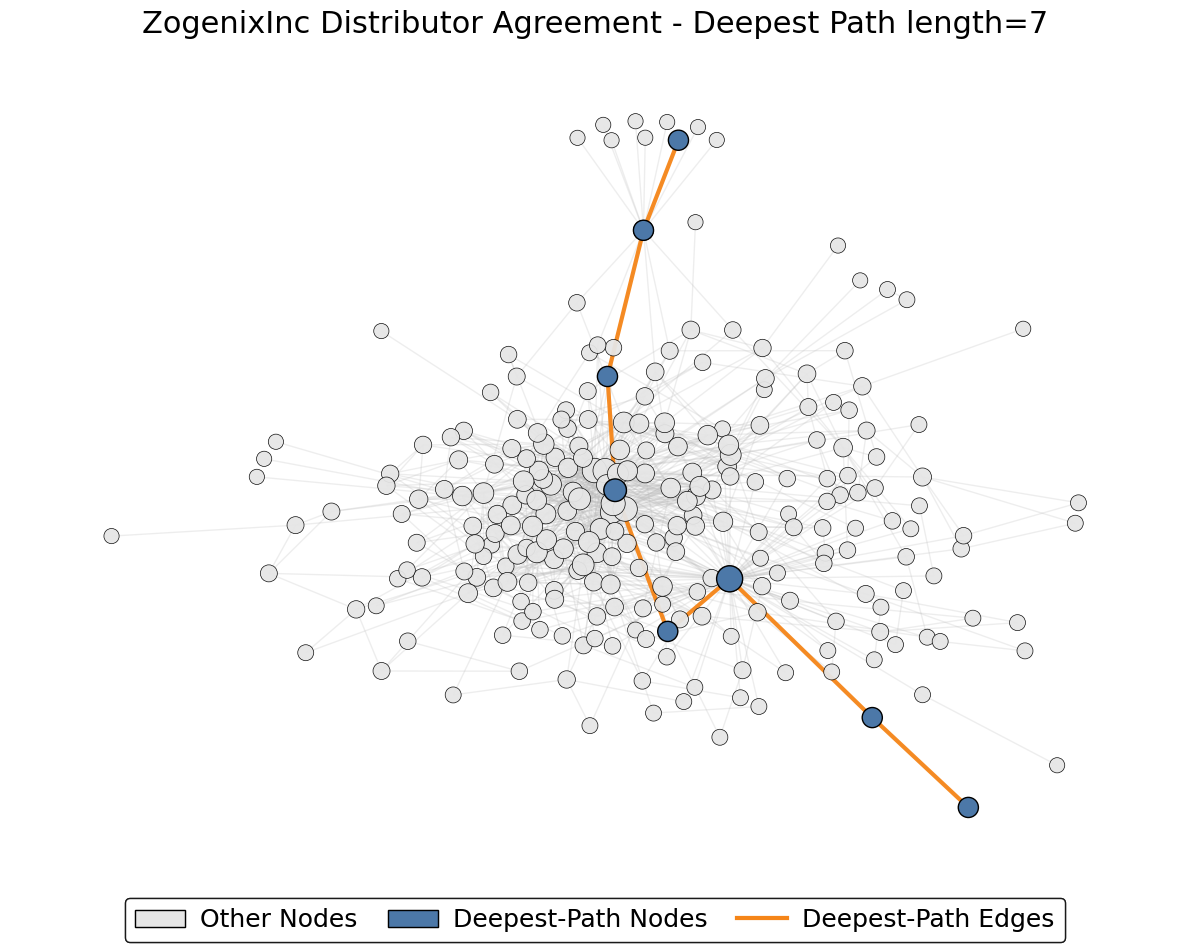

[sanity] Orphans in FULL graph: 0   |   Articulation points in main component: 11


In [24]:
def longest_shortest_path(G):
    if not G.nodes():
        return []

    longest_path = []
    for source in G.nodes():
        try:
            shortest_paths = nx.shortest_path(G, source=source)
        except nx.NetworkXNoPath:
            continue

        for target, path in shortest_paths.items():
            if len(path) > len(longest_path):
                longest_path = path

    return longest_path

def draw_deepest_path_clean():
    path_nodes = longest_shortest_path(H)

    fig = plt.figure(figsize=(12, 10)); ax = plt.gca()
    title = f"ZogenixInc Distributor Agreement - Deepest Path length={len(path_nodes)-1}" if len(path_nodes) >= 2 \
            else "Deepest Path (not found or graph too small)"
    ax.set_title(title, pad=12, color="black", fontsize=FONTSIZE)

    nx.draw_networkx_edges(H, pos, width=1.0, alpha=0.25, edge_color="#BBBBBB")
    nx.draw_networkx_nodes(H, pos, nodelist=list(H.nodes()),
                           node_size=[nsize(n) for n in H.nodes()],
                           node_color="#E6E6E6", edgecolors="black", linewidths=0.5, alpha=0.95)

    if len(path_nodes) >= 2:
        path_edges = list(zip(path_nodes[:-1], path_nodes[1:]))
        nx.draw_networkx_nodes(H, pos, nodelist=path_nodes,
                               node_size=[max(nsize(n), 210) for n in path_nodes],
                               node_color="#4C78A8", edgecolors="black", linewidths=1.0, alpha=1.0)
        nx.draw_networkx_edges(H, pos, edgelist=path_edges, width=3.0, alpha=0.95,
                               edge_color="#F58518")

        handles = [
            Patch(facecolor="#E6E6E6", edgecolor="black", label="Other Nodes"),
            Patch(facecolor="#4C78A8", edgecolor="black", label="Deepest-Path Nodes"),
            Line2D([0], [0], color="#F58518", lw=3.0, label="Deepest-Path Edges")
        ]
        plt.subplots_adjust(bottom=0.10)
        fig_bottom_legend(fig, handles, title=None, y=0.04)

    ax.set_axis_off()
    plt.tight_layout(rect=(0, 0.10, 1, 1))
    if SAVE:
        plt.savefig(os.path.join(OUT_DIR, "03_deepest_path_clean.png"), dpi=FIG_DPI, bbox_inches="tight")
    plt.show()



draw_deepest_path_clean()

print(f"[sanity] Orphans in FULL graph: {len(orphans_all)}   |   Articulation points in main component: {len(art_points_H)}")

In [25]:
!apt-get -qq update
!apt-get -qq install graphviz graphviz-dev pkg-config python3-dev
!pip install -q pygraphviz networkx matplotlib


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Using graph file: /content/drive/MyDrive/output_gemini_robust/Copy of ADIANUTRITION,INC_04_01_2005-EX-10.D2-RESELLER AGREEMENT_nupunkt_graph.json
Loaded 57 nodes / 137 edges
Graph ready: 57 nodes


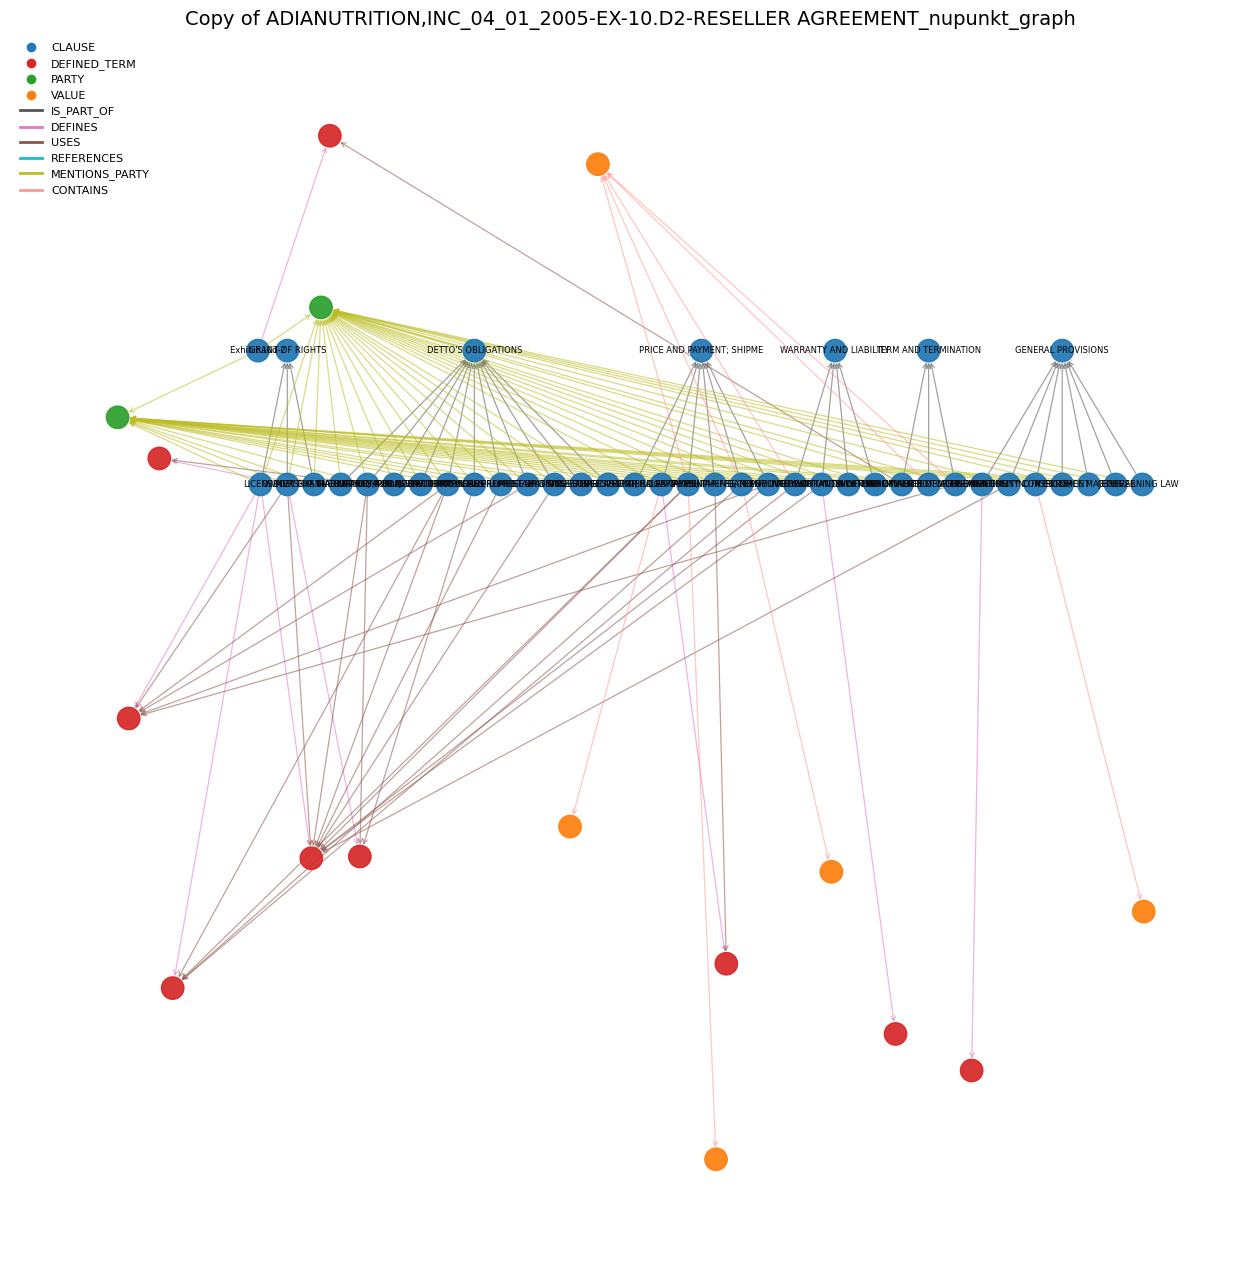

In [26]:
#@title Visualize with Graphviz + pydot
!apt-get -qq install graphviz
!pip install -q pydot networkx matplotlib

import json, glob, random
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout

json_files = sorted(glob.glob(f"{GRAPH_DIR}/*.json"))
assert json_files, f"No *.json in {GRAPH_DIR}"

graph_path = json_files[2]
print("Using graph file:", graph_path)

with open(graph_path, encoding="utf-8") as f:
    graph_json = json.load(f)

nodes = graph_json["nodes"]
edges = graph_json["edges"]
print(f"Loaded {len(nodes)} nodes / {len(edges)} edges")

G = nx.DiGraph()
for n in nodes:
    G.add_node(n["id"], ntype=n.get("type","NODE"), **n.get("attrs",{}))
for e in edges:
    G.add_edge(e["src"], e["tgt"], etype=e.get("type","EDGE"))

print("Graph ready:", G.number_of_nodes(), "nodes")

clauses = [n for n,d in G.nodes(data=True) if d["ntype"]=="CLAUSE"]
tree_edges = [(u,v) for u,v,d in G.edges(data=True) if d["etype"]=="IS_PART_OF"]

T = nx.DiGraph()
T.add_nodes_from(clauses)
T.add_edges_from([(v,u) for u,v in tree_edges])

pos = graphviz_layout(T, prog="dot")

HALO_R = 0.7
for n,d in G.nodes(data=True):
    if n in pos:
        continue
    anchors = [x for x in G.predecessors(n) if x in pos] \
            + [x for x in G.successors(n) if x in pos]
    anchor = anchors[0] if anchors else random.choice(clauses)
    ax, ay = pos[anchor]
    pos[n] = (ax + random.uniform(-HALO_R, HALO_R),
              ay - random.uniform(0.2, HALO_R))

halo_nodes = [n for n in G if n not in clauses]
pos = nx.spring_layout(G, pos=pos, fixed=clauses,
                       iterations=30, k=0.25, seed=42)

plt.figure(figsize=(16, 16))
node_type_colour = {
    "CLAUSE":        "#1f77b4",
    "DEFINED_TERM":  "#d62728",
    "PARTY":         "#2ca02c",
    "VALUE":         "#ff7f0e",
}
edge_type_colour = {
    "IS_PART_OF":     "#555555",
    "DEFINES":        "#e377c2",
    "USES":           "#8c564b",
    "REFERENCES":     "#17becf",
    "MENTIONS_PARTY": "#bcbd22",
    "CONTAINS":       "#ff9896",
}

node_colours = [
    node_type_colour.get(G.nodes[n]["ntype"], "#7f7f7f") for n in G.nodes
]
nx.draw_networkx_nodes(
    G, pos, node_color=node_colours, node_size=260, alpha=.92
)

for etype, colour in edge_type_colour.items():
    edges_of_type = [
        (u, v) for u, v, d in G.edges(data=True) if d.get("etype") == etype
    ]
    if not edges_of_type:
        continue
    nx.draw_networkx_edges(
        G, pos,
        edgelist=edges_of_type,
        edge_color=colour,
        arrows=True,
        arrowstyle="->",
        arrowsize=8,
        width=0.9,
        alpha=.55
    )

labels = {
    n: (G.nodes[n].get("title") or n)[:25]
    for n in clauses
}
nx.draw_networkx_labels(G, pos, labels, font_size=6)

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], marker="o", color="w",
           markerfacecolor=c, markersize=8, label=ntype)
    for ntype, c in node_type_colour.items()
]
legend_handles += [
    Line2D([0], [0], color=c, lw=2, label=etype)
    for etype, c in edge_type_colour.items()
]
plt.legend(
    handles=legend_handles,
    loc="upper left",
    fontsize=8,
    frameon=False
)

plt.title(Path(graph_path).stem, fontsize=14)
plt.axis("off")
plt.show()



In [27]:
#@title Interactive Graph Display
!pip install -q networkx matplotlib pyvis

import ipywidgets as widgets
import json as _json


GRAPH_DIR = "/content/drive/MyDrive/output_gemini_robust"
drive.mount("/content/drive", force_remount=False)

files = sorted(glob.glob(f"{GRAPH_DIR}/*.json"))
assert files, f"No *.json in {GRAPH_DIR}"
picker = widgets.Dropdown(options=[Path(f).name for f in files],
                          description="Graph:")
btn = widgets.Button(description="Visualize", button_style="success")
display(widgets.VBox([picker, btn]))

def load_graph(fp):
    data = json.load(open(fp, "r", encoding="utf-8"))
    G = nx.DiGraph()
    for n in data["nodes"]:
        G.add_node(n["id"], ntype=n["type"], **n.get("attrs", {}))
    for e in data["edges"]:
        G.add_edge(e["src"], e["tgt"], etype=e["type"])
    return G, data.get("contract_id", Path(fp).stem)

NODE_C = {"CLAUSE":"#1f77b4","DEFINED_TERM":"#d62728","PARTY":"#2ca02c","VALUE":"#ff7f0e"}
EDGE_C = {"IS_PART_OF":"#888888","DEFINES":"#e377c2","USES":"#8c564b",
          "REFERENCES":"#17becf","MENTIONS_PARTY":"#bcbd22","CONTAINS":"#ff9896"}

def on_visualize(_):
    fp = str(Path(GRAPH_DIR) / picker.value)
    G, name = load_graph(fp)
    print(f"Loaded {G.number_of_nodes()} nodes / {G.number_of_edges()} edges")

    plt.figure(figsize=(14,14))
    pos = nx.spring_layout(G, k=0.7, seed=42)
    nx.draw_networkx_nodes(G, pos,
        node_color=[NODE_C.get(G.nodes[n]['ntype'],"#777") for n in G],
        node_size=240, alpha=.9)
    FADE = {"USES","REFERENCES"}
    for et,col in EDGE_C.items():
        elist = [(u,v) for u,v,d in G.edges(data=True) if d["etype"]==et]
        alpha = 0.15 if et in FADE else 0.45
        nx.draw_networkx_edges(G, pos, edgelist=elist, edge_color=col,
                               arrows=True, arrowstyle="->", width=0.8,
                               arrowsize=7, alpha=alpha)
    labels = {n:(G.nodes[n].get("title") or n)[:25]
              for n,d in G.nodes(data=True) if d['ntype']=="CLAUSE"}
    nx.draw_networkx_labels(G, pos, labels, font_size=6)
    from matplotlib.lines import Line2D
    handles = ([Line2D([0],[0],marker='o',color='w',markerfacecolor=c,
                       markersize=8,label=k) for k,c in NODE_C.items()] +
               [Line2D([0],[0],color=c,lw=2,label=k) for k,c in EDGE_C.items()])
    plt.legend(handles=handles, loc="upper left", fontsize=7, frameon=False)
    plt.title(name, fontsize=13)
    plt.axis("off")
    plt.show()

    #PYVIS INTERACTIVE
    net = Network(height="750px", directed=True, notebook=True,
                  cdn_resources="in_line")
    net.barnes_hut()

    for n,d in G.nodes(data=True):
        net.add_node(
            n,
            label=(d.get("title") or n)[:24],
            color=NODE_C.get(d["ntype"], "#777"),
            title=f"<b>{n}</b><br>{d.get('title','')}",
            group=d["ntype"]
        )

    for u,v,d in G.edges(data=True):
        et = d["etype"]
        net.add_edge(u,v, title=et, color=EDGE_C.get(et,"#999"),
                     group=et)

    js = f"""
    (() => {{
      const edgeGroups = {_json.dumps(list(EDGE_C.keys()))};
      const nodeGroups = {_json.dumps(list(NODE_C.keys()))};

      const makePanel = (groups, label, yShift) => {{
        const box = document.createElement('div');
        box.style.cssText = `position:fixed;right:10px;top:${{yShift}}px;\
                             background:#fff;border:1px solid #bbb;\
                             padding:6px 8px;font-size:13px;\
                             font-family:sans-serif;z-index:9999;`;
        const head = document.createElement('div');
        head.textContent = label; head.style.fontWeight='600';
        box.appendChild(head);

        groups.forEach(g => {{
          const row = document.createElement('div');
          const cb  = document.createElement('input');
          cb.type='checkbox'; cb.checked=true;
          cb.onchange = () => {{
            const coll = (label=='Edges' ? network.body.data.edges
                                         : network.body.data.nodes);
            const items = coll.get();
            items.forEach(e => {{ if(e.group===g) e.hidden = !cb.checked; }});
            coll.update(items);
          }};
          row.appendChild(cb);
          row.appendChild(document.createTextNode(' '+g));
          box.appendChild(row);
        }});
        document.body.appendChild(box);
      }};

      makePanel(edgeGroups, 'Edges', 10);
      makePanel(nodeGroups, 'Nodes', 160);
    }})();
    """
    net.html += f"<script>{js}</script>"
    net.show("interactive_graph.html")

btn.on_click(on_visualize)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:

#@title Convert graph files to csv
SRC_DIR  = "/content/drive/MyDrive/output_gemini_robust"
DEST_DIR = "/content/drive/MyDrive/neo4j_csv"

import json, glob, pandas as pd
from pathlib import Path

Path(DEST_DIR).mkdir(parents=True, exist_ok=True)

graph_files = sorted(glob.glob(f"{SRC_DIR}/*.json"))
print(f"Found {len(graph_files)} graph file(s)")

for fp in graph_files:
    stem = Path(fp).stem
    with open(fp, encoding="utf-8") as f:
        data = json.load(f)

    df_nodes = pd.DataFrame(data["nodes"])
    df_edges = pd.DataFrame(data["edges"])

    nodes_csv = Path(DEST_DIR) / f"{stem}_nodes.csv"
    edges_csv = Path(DEST_DIR) / f"{stem}_edges.csv"
    df_nodes.to_csv(nodes_csv, index=False)
    df_edges.to_csv(edges_csv, index=False)
    print(f"✓ {stem}: {nodes_csv.name} / {edges_csv.name}")

print(f"\nAll done. CSVs saved in {DEST_DIR}")


Found 73 graph file(s)
✓ Copy of ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGREEMENT_nupunkt_graph: Copy of ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGREEMENT_nupunkt_graph_nodes.csv / Copy of ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGREEMENT_nupunkt_graph_edges.csv
✓ Copy of ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT_nupunkt_graph: Copy of ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT_nupunkt_graph_nodes.csv / Copy of ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT_nupunkt_graph_edges.csv
✓ Copy of ADIANUTRITION,INC_04_01_2005-EX-10.D2-RESELLER AGREEMENT_nupunkt_graph: Copy of ADIANUTRITION,INC_04_01_2005-EX-10.D2-RESELLER AGREEMENT_nupunkt_graph_nodes.csv / Copy of ADIANUTRITION,INC_04_01_2005-EX-10.D2-RESELLER AGREEMENT_nupunkt_graph_edges.csv
✓ Copy of AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distributor Agreement_nupunkt_graph: Copy of AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distributor Agreement_nupunkt_graph_nodes.csv / Copy of AIRSPANNETWORKSINC_04_

In [29]:
#@title Convert graph files to neo4j

import pandas as pd, json, os
from pathlib import Path

SRC_DIR  = "/content/drive/MyDrive/output_gemini_robust"
DEST_DIR = "/content/drive/MyDrive/neo4j_csv_v2"
Path(DEST_DIR).mkdir(parents=True, exist_ok=True)

for fp in Path(SRC_DIR).glob("*.json"):
    data = json.load(open(fp))
    stem = fp.stem

    df_nodes  = pd.DataFrame(data["nodes"])
    df_edges  = pd.DataFrame(data["edges"])

    for label, sub in df_nodes.groupby("type"):
        fn = Path(DEST_DIR) / f"{stem}_{label}.csv"
        sub = sub.copy()
        sub.insert(0, "labels:LABEL", label)
        sub.rename(columns={"id": "id:ID"}, inplace=True)
        sub.to_csv(fn, index=False)

    df_edges.rename(columns={"src": "src:START_ID",
                             "tgt": "tgt:END_ID",
                             "type": "type:TYPE"}, inplace=True)
    df_edges.to_csv(Path(DEST_DIR)/f"{stem}_edges.csv", index=False)
    print("✓ exported", stem)


✓ exported Copy of ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGREEMENT_nupunkt_graph
✓ exported Copy of ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT_nupunkt_graph
✓ exported Copy of ADIANUTRITION,INC_04_01_2005-EX-10.D2-RESELLER AGREEMENT_nupunkt_graph
✓ exported Copy of AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distributor Agreement_nupunkt_graph
✓ exported Copy of AIRTECHINTERNATIONALGROUPINC_05_08_2000-EX-10.4-FRANCHISE AGREEMENT_nupunkt_graph
✓ exported Copy of ASIANDRAGONGROUPINC_08_11_2005-EX-10.5-Reseller Agreement_nupunkt_graph
✓ exported Copy of AgapeAtpCorp_20191202_10-KA_EX-10.1_11911128_EX-10.1_Supply Agreement_nupunkt_graph
✓ exported Copy of AudibleInc_20001113_10-Q_EX-10.32_2599586_EX-10.32_Co-Branding Agreement_ Marketing Agreement_ Investment Distribution Agreement_nupunkt_graph
✓ exported Copy of BELLRINGBRANDS,INC_02_07_2020-EX-10.18-MASTER SUPPLY AGREEMENT_nupunkt_graph
✓ exported Copy of BIOFRONTERAAG_04_29_2019-EX-4.17-SUPPLY AGREEMENT_nupunkt_graph
✓ expor

In [30]:
#@title Create a complete report for graph metrics for the entire dataset

!pip install -q networkx pandas

from pathlib import Path
import json, glob, networkx as nx, pandas as pd
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

SRC_DIR  = "/content/drive/MyDrive/output_gemini_robust"
DEST_CSV = "/content/drive/MyDrive/contract_metrics.csv"

def dependency_depth(G):
    depth = 0
    for v in G.nodes():
        dists = nx.single_source_shortest_path_length(G, v)
        if dists:
            depth = max(depth, max(dists.values()))
    return depth

def metrics_for(G, cid):
    n, m  = G.number_of_nodes(), G.number_of_edges()
    loops = nx.number_of_selfloops(G)

    dens  = nx.density(G)
    depth = dependency_depth(G)

    if loops:
        k_core_k = None
    else:
        try:
            k_core_k = max(nx.core_number(G.to_undirected()).values())
        except Exception:
            k_core_k = None

    in_deg  = dict(G.in_degree())
    out_deg = dict(G.out_degree())

    orphan = sum(1 for v in G if in_deg[v]==0)
    leaf   = sum(1 for v in G if out_deg[v]==0)

    art_points = list(nx.articulation_points(G.to_undirected()))

    defs = {n for n, d in G.nodes(data=True) if d['ntype'] == 'DEFINED_TERM'}
    used = {v for u, v, e in G.edges(data=True) if e.get('etype') == 'USES'}
    undefined = used - defs
    unused    = defs - used

    return {
        "contract_id": cid,
        "has_self_loops": bool(loops),
        "nodes": n, "edges": m,
        "density": round(dens,4),
        "dependency_depth": depth,
        "k_core_k": k_core_k,
        "orphans": orphan,
        "leaves": leaf,
        "orphan_ratio": round(orphan/n,3),
        "leaf_ratio":   round(leaf/n,3),
        "articulation_points": len(art_points),
        "undefined_terms": len(undefined),
        "unused_terms":    len(unused),
    }

rows = []
for fp in glob.glob(f"{SRC_DIR}/*.json"):
    data = json.load(open(fp))
    G = nx.DiGraph()
    for n in data["nodes"]:
        G.add_node(n["id"], ntype=n["type"], **n.get("attrs", {}))
    for e in data["edges"]:
        G.add_edge(e["src"], e["tgt"], etype=e["type"])
    rows.append(metrics_for(G, data.get("contract_id", Path(fp).stem)))
    print("✓ analysed", Path(fp).name)

df = pd.DataFrame(rows)
df.to_csv(DEST_CSV, index=False)
print("\nCSV saved to →", DEST_CSV)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ analysed Copy of ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGREEMENT_nupunkt_graph.json
✓ analysed Copy of ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT_nupunkt_graph.json
✓ analysed Copy of ADIANUTRITION,INC_04_01_2005-EX-10.D2-RESELLER AGREEMENT_nupunkt_graph.json
✓ analysed Copy of AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distributor Agreement_nupunkt_graph.json
✓ analysed Copy of AIRTECHINTERNATIONALGROUPINC_05_08_2000-EX-10.4-FRANCHISE AGREEMENT_nupunkt_graph.json
✓ analysed Copy of ASIANDRAGONGROUPINC_08_11_2005-EX-10.5-Reseller Agreement_nupunkt_graph.json
✓ analysed Copy of AgapeAtpCorp_20191202_10-KA_EX-10.1_11911128_EX-10.1_Supply Agreement_nupunkt_graph.json
✓ analysed Copy of AudibleInc_20001113_10-Q_EX-10.32_2599586_EX-10.32_Co-Branding Agreement_ Marketing Agreement_ Investment Distribution Agreement_nupunkt_graph.json
✓ analysed Copy o

In [31]:
df.head()

,contract_id,has_self_loops,nodes,edges,density,dependency_depth,k_core_k,orphans,leaves,orphan_ratio,leaf_ratio,articulation_points,undefined_terms,unused_terms
0,Copy of ACCURAYINC_09_01_2010-EX-10.31-DISTRIB...,False,14,16,0.0879,3,2.0,5,7,0.357,0.500,4,0,4
1,Copy of ADAMSGOLFINC_03_21_2005-EX-10.17-ENDOR...,True,50,108,0.0441,2,NaN,28,21,0.560,0.420,6,0,0
2,"Copy of ADIANUTRITION,INC_04_01_2005-EX-10.D2-...",False,57,137,0.0429,2,4.0,33,21,0.579,0.368,8,0,2
3,Copy of AIRSPANNETWORKSINC_04_11_2000-EX-10.5-...,False,161,530,0.0206,3,5.0,98,53,0.609,0.329,13,0,4
4,Copy of AIRTECHINTERNATIONALGROUPINC_05_08_200...,True,147,674,0.0314,7,NaN,60,63,0.408,0.429,20,0,0
